In [50]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1 (3 points)

Consider the following toy dataset:

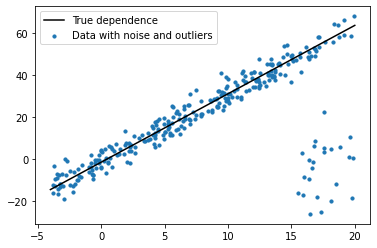

In [111]:
true_function = lambda x: 3.25 * x - 1.47
noize_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
  x = np.random.uniform(*limits, size=N)
  y = true_function(x) + noize_function(x)

  return x[:,None], y

X, y = generate_dataset()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend();

Implement a linear model $\hat y(x|w) = w_1\cdot x + w_0$ with MAE loss:
$$\text{MAE}(w) = \frac{1}{N}\sum_{i=1}^N\left|y_i - \hat y(x_i|w)\right|,$$
using gradient descent optimization in `numpy`.

*Hint: introduce a constant feature to account for the bias term to make the formulas simpler.*

Plot the learning curve and the final fit. Also, fit the same data with `sklearn`'s `LinearRegression`, and compare the two fits on the same plot. What do you observe? Write a short comment.

In [52]:
from tqdm import trange, tqdm

In [53]:

#introduce a constant feature to account for the bias term to make the formulas simpler.
X_tmp = np.column_stack((X, np.ones(len(X))))

#initializing w
w  = np.random.randn(len(X_tmp[0]))

#loss vlaues in list
loss_values = []
learning_rate = 0.1


# Training loop
for _ in trange(1000):
  # Your turn: calculate the gradient of MAE with respect to w:
  g_sign = np.sign(X_tmp @ w - y)
  gradient = np.sum(X_tmp * g_sign.reshape(len(X_tmp),1)/len(X_tmp) , axis = 0)

  # Gradient descent step
  w -= learning_rate * gradient

  # Calculate and record the new loss value
  loss_values.append(
      np.mean(np.abs(X_tmp @ w - y))
  )



100%|██████████| 1000/1000 [00:00<00:00, 17889.44it/s]


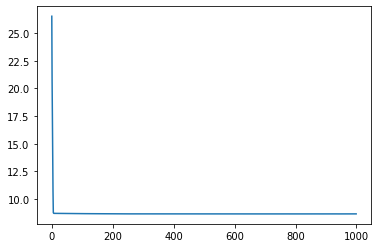

In [54]:
# Plotting the evolution of loss values
plt.plot(loss_values);
plt.show()

In [55]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X, y)

LinearRegression()

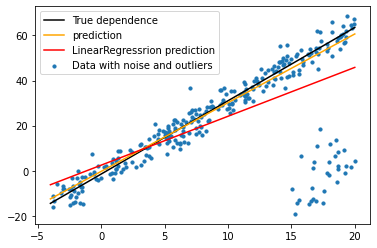

In [56]:
limits = (-4., 20.)
x = np.linspace(*limits, 101)
x_expanded = np.column_stack((x, np.ones(len(x))))
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.plot(x, x_expanded @ w,c ='orange', label='prediction')
plt.plot(x, model.predict(x[:,None]),c= 'Red', label='LinearRegressrion prediction')
plt.legend();


In [57]:
print(model.coef_, model.intercept_)

[2.16798992] 2.475440436373688


In [58]:
print (w)

[ 3.04774009 -0.29404279]


From true function value we can see that Coef and intercept should be equal to [3.25 ,1.47] , our linear model with gradiant desent model score [ 3.04774009, -0.29404279] which is better than the score optained from Linear regresseor [2.16798992, 2.475440436373688] most probably becuase linear regresseor uses the Ordinary Least Squares solver from scipy , rather than MAE

## Task 2 (2 + 1 points)

* Wrap your solution from the previous task into a class. Plot the learning curve and the final fit. Compare and comment your results with the previos ones. **(2 points)**

* Make it possible to choose a loss function. **(1 point)**

In [112]:
from sklearn.base import BaseEstimator, RegressorMixin

In [143]:
class LinearRergessionSGD(BaseEstimator, RegressorMixin):
    def __init__(self ,
                 batch_size: int=10,
                 lr: float=1e-2,
                 n_iters: int=10,
                 loss:str= "MAE") -> None:

        methods_from = ["MSE", "MAE"]

        self.batch_size = batch_size
        self.lr = lr
        self.n_iters = n_iters
        self.loss = loss
        self.w_history = []
        if self.loss not in methods_from:
           print ("Error, the methods parameter can only be ", methods_from)


    def fit(self, x, y):
      #introduce a constant feature to account for the bias term to make the formulas simpler.
      n = len(x)
      self.n = n
    
      X_tmp = np.column_stack((x, np.ones(self.n)))
      w  = np.random.randn(len(X_tmp[0]))

      self.X = X_tmp
      self.y = y

      for i in trange(self.n_iters):
         w -= self.lr * self.getGradient(w)
         self.update_loss(w)
      self.w = w

        #raise NotImplementedError
    def getGradient(self, weight):
      methods_from = ["MSE", "MAE"]
      if self.loss == "MSE":
        gradient = -2 * (self.X.T @(self.y - self.X @ weight ))/ self.X.shape[0]
      elif self.loss == 'MAE':
         g_sign = np.sign(self.X @ weight - self.y)
         gradient = np.sum(self.X * g_sign.reshape(self.n,1)/self.n , axis = 0)
      return gradient
    
    def update_loss(self, weight):
      if self.loss == "MSE":
        self.w_history.append(((self.X @ weight - self.y)**2).mean())
      elif self.loss == 'MAE':
        self.w_history.append(np.mean(np.abs(self.X @ weight - self.y)))
      
    def clear_loss(self):
      self.w_history.clear()


    def predict(self, x):
      print (x.shape)
      x_expanded = np.column_stack((x, np.ones(len(x))))
      print (x_expanded.shape)
      print (self.w.shape)
      return x_expanded @ self.w
    
    def fit_predict(self, x, y):
      self.fit(x,y)
      return self.predict(x)

In [129]:
model = LinearRergessionSGD(lr = 0.1, n_iters = 1000 ,loss ="MAE")

In [130]:
X.shape

(300, 1)

In [131]:
model.fit(X,y)

100%|██████████| 1000/1000 [00:00<00:00, 18974.97it/s]


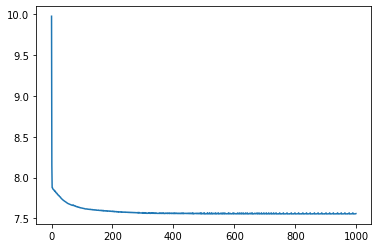

In [132]:
# Plotting the evolution of loss values
plt.plot(model.w_history);
plt.show()

(101,)


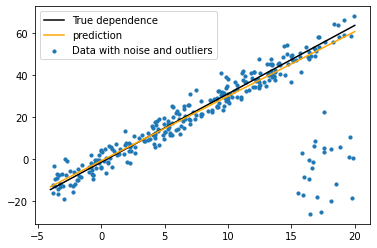

In [133]:
limits = (-4., 20.)
x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.plot(x, model.predict(x),c ='orange', label='prediction')
plt.legend();


In [134]:
print(model.w)

[ 3.06983354 -0.81123367]


we can see that the values are close between the output of Task 1 [ 3.04774009 -0.29404279] and Task 2 [ 3.04318045 -0.2636259 ]

In [154]:
def true_function(x):
  return np.sin(3 * x + 0.8) + np.sin(1. / (x + 1.23))

In [155]:
def gen_dataset(N, func, lims=(-1., 1.), noise_lvl=0.2):
  x = np.random.uniform(*lims, size=N)
  y = func(x) + noise_lvl * np.random.normal(size=x.shape)
  return x[:,None], y

In [156]:
X, y = gen_dataset(25, true_function)

In [157]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [158]:
poly_expand = PolynomialFeatures(5, include_bias=False)
linear_model = LinearRergessionSGD(lr = 0.1, n_iters = 1000 ,loss ="MAE")
model = make_pipeline(
    poly_expand, linear_model
)

In [159]:
model.fit(X,y)

100%|██████████| 1000/1000 [00:00<00:00, 24907.38it/s]


Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=False)),
                ('linearrergessionsgd',
                 LinearRergessionSGD(lr=0.1, n_iters=1000))])

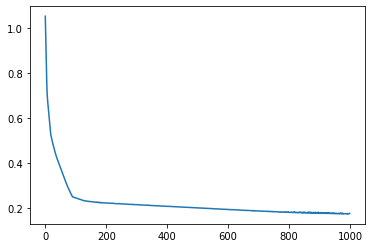

In [160]:
# Plotting the evolution of loss values
plt.plot(linear_model.w_history);
plt.show()

(101, 5)
(101, 6)
(6,)


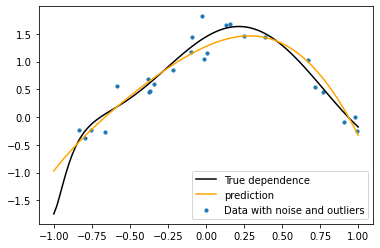

In [161]:
limits = (-1., 1.)
x = np.linspace(*limits, 101)
#x_expanded =  poly_expand.transform(x[:,None])
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.plot(x, model.predict(x[:,None]),c ='orange', label='prediction')
plt.legend();
